<a href="https://colab.research.google.com/github/cs18b028/Object-Classification/blob/main/ObjectClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from PIL import Image
from torchvision.transforms import ToTensor
import random
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Data collection

# 2. Data Cleaning


1.   Data Augmentation
2.   Data Enhanching - greyscaling/maxpooling 
3.   Resizing
4.   Shuffling properly



In [3]:
Clothes_Categories = ["Dresses", "Shirts", "Shorts", "Skirt", "T Shirt", "Trousers"]
Footwear_Categories = ["Sandals", "Shoes", "Slippers"]
labels = ["Footwear","Topwear","Dress","Short","Trouser"]

In [ ]:
def process_images(path, new_path, name):
  temp = os.listdir(path)
  files_list = [path + '/' + fname for fname in temp]
  for index, img_path in enumerate(files_list):
    try:
      image = Image.open(img_path).convert("L")
      image = image.resize((150, 112), Image.ANTIALIAS)
      image.save(new_path+f'/{name}_'+str(index)+'.jpg')
      print(new_path+f'/{name}_'+str(index)+'.jpg')
      datagen = ImageDataGenerator(
              rotation_range=40,
              width_shift_range=0.2,
              height_shift_range=0.2,
              shear_range=0.2,
              zoom_range=0.2,
              horizontal_flip=True,
              fill_mode='nearest')

      x = img_to_array(image) 
      x = x.reshape((1,) + x.shape) 
      i = 1
      for batch in datagen.flow(x, batch_size=1,
                                save_to_dir=new_path, save_prefix=cat, save_format='jpeg'):
          i += 1
          if i > 20:
              break
    except Exception as e:
      print(e)

In [ ]:
#Clothes Processing
clothes_path = '/content/drive/Shareddrives/AI ML Project/Clothes'
for cat in Clothes_Categories:
  folder_path = clothes_path+'/'+cat
  new_path = clothes_path+f'/{cat}_Processed'
  os.mkdir(new_path)
  process_images(folder_path, new_path, cat)

In [ ]:
footwear_path = '/content/drive/Shareddrives/AI ML Project/Footwear'
for cat in Footwear_Categories:
  folder_path = footwear_path+'/'+cat
  new_path = footwear_path+f'/{cat}_Processed'
  os.mkdir(new_path)
  process_images(folder_path, new_path, cat)

# 3. Clustering before labelling

In [4]:
import pickle

file_train_X = open('/content/drive/Shareddrives/AI ML Project/dataset_train_X','rb')
train_X = pickle.load(file_train_X)
file_train_X.close()

file_train_y = open('/content/drive/Shareddrives/AI ML Project/dataset_train_y','rb')
train_y = pickle.load(file_train_y)
file_train_y.close()

file_test_X = open('/content/drive/Shareddrives/AI ML Project/dataset_test_X','rb')
test_X = pickle.load(file_test_X)
file_test_X.close()

file_test_y = open('/content/drive/Shareddrives/AI ML Project/dataset_test_y','rb')
test_y = pickle.load(file_test_y)
file_test_y.close()

In [5]:
train_set = list(zip(train_X, train_y))
random.shuffle(train_set)
train_X, train_y = zip(*train_set)
train_X = list(train_X)
train_y = list(train_y)

In [6]:
test_set = list(zip(test_X, test_y))
random.shuffle(test_set)
test_X, test_y = zip(*test_set)
test_X =list(test_X)
test_y = list(test_y)

# 5. Feature Engineering

In [7]:
# type(train_X)
train_X = np.array(train_X)
train_X = train_X / 255
train_X_2d = train_X.reshape((-1, 112*150))
test_X = np.array(test_X)
test_X = test_X / 255
test_X_2d = test_X.reshape((-1, 112*150))
print(train_X.shape)

(5004, 112, 150, 1)


In [8]:
labels = ["Footwear","Topwear","Dress","Short","Trouser"]


for i in range(len(train_y)):
  if train_y[i] == "Dresses" or train_y[i] == "Skirt":
    train_y[i] = "Dress"
  elif train_y[i] == "T Shirt" or train_y[i] == "Shirts":
    train_y[i] = "Topwear"
  elif train_y[i] == "Sandals" or train_y[i] == "Shoes" or train_y[i] == "Slippers":
    train_y[i] = "Footwear"
  elif train_y[i] == "Trousers":
    train_y[i] = "Trouser"
  elif train_y[i] == "Shorts":
    train_y[i] = "Short"


for i in range(len(test_y)):
  if test_y[i] == "Dresses" or test_y[i] == "Skirt":
    test_y[i] = "Dress"
  elif test_y[i] == "T Shirt" or test_y[i] == "Shirts":
    test_y[i] = "Topwear"
  elif test_y[i] == "Sandals" or test_y[i] == "Shoes" or test_y[i] == "Slippers":
    test_y[i] = "Footwear"
  elif test_y[i] == "Trousers":
    test_y[i] = "Trouser"
  elif test_y[i] == "Shorts":
    test_y[i] = "Short"

In [9]:
X = np.concatenate((train_X_2d,test_X_2d))
print(X.shape)

(6260, 16800)


In [10]:
pca = PCA(2)
df = pca.fit_transform(X)

In [11]:
kmeans = KMeans(n_clusters= 5)
label = kmeans.fit_predict(df)
print(label)

[1 1 4 ... 0 0 4]


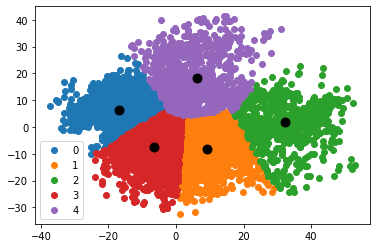

In [12]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

# 4. Manual Labelling

In [ ]:
def generate_data(path):
  temp = os.listdir(path)
  files_list = [path + '/' + fname for fname in temp]
  random.shuffle(files_list)
  train_size = int(4/5*len(files_list))
  train = []
  test = []
  for i, filename in enumerate(files_list[:train_size]):
    img = Image.open(filename)
    x = img_to_array(img)
    train.append(x)
    if i%10==0:
      print(f"{i} Train Done!")
  for i, filename in enumerate(files_list[train_size:]):
    img = Image.open(filename)
    x = img_to_array(img)
    test.append(x)
    if i%10==0:
      print(f"{i} Test Done!")
  return (train, test)

In [ ]:
train_X = []
train_y = []
test_X = []
test_y = []
for cat in Clothes_Categories:
  folder_path = f'/content/drive/Shareddrives/AI ML Project/Clothes/{cat}_Processed'
  (train, test) = generate_data(folder_path)
  # print(cat)
  train_X = train_X + train
  train_y = train_y + [cat]*len(train)
  test_X = test_X + test
  test_y = test_y + [cat]*len(test)

for cat in Footwear_Categories:
  folder_path = f'/content/drive/Shareddrives/AI ML Project/Footwear/{cat}_Processed'
  (train, test) = generate_data(folder_path)
  # print(cat)
  train_X = train_X + train
  train_y = train_y + [cat]*len(train)
  test_X = test_X + test
  test_y = test_y + [cat]*len(test)

In [ ]:
pickle.dump(train_X, open('/content/drive/Shareddrives/AI ML Project/dataset_train_X', "wb"))
pickle.dump(train_y, open('/content/drive/Shareddrives/AI ML Project/dataset_train_y', "wb"))
pickle.dump(test_X, open('/content/drive/Shareddrives/AI ML Project/dataset_test_X', "wb"))
pickle.dump(test_y, open('/content/drive/Shareddrives/AI ML Project/dataset_test_y', "wb"))

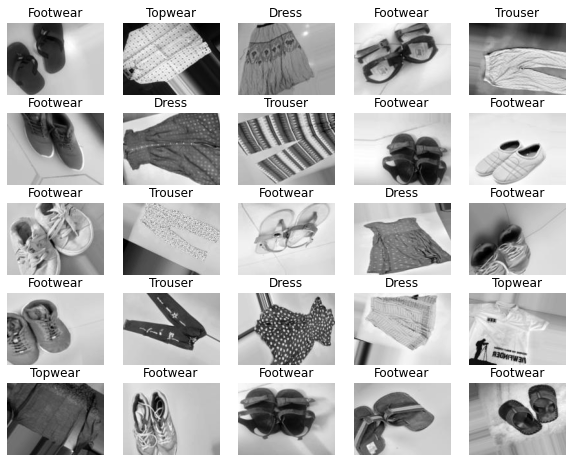

In [13]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    img = train_X[i]
    figure.add_subplot(rows, cols, i)
    plt.title(train_y[i])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [14]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(labels)
list(le.classes_)
print(train_y[:10], test_y[:10])
train_y = le.transform(train_y)
test_y = le.transform(test_y)
print(train_y[:10], test_y[:10])

['Footwear', 'Footwear', 'Topwear', 'Dress', 'Footwear', 'Trouser', 'Footwear', 'Dress', 'Trouser', 'Footwear'] ['Topwear', 'Footwear', 'Footwear', 'Dress', 'Footwear', 'Dress', 'Footwear', 'Footwear', 'Footwear', 'Dress']
[1 1 3 0 1 4 1 0 4 1] [3 1 1 0 1 0 1 1 1 0]


# 6. Build Classifier

Analysis of Classifiers

In [15]:
# AUC Score
def calc_auc_score(y_test, y_prob, classes):

    for cls in classes:
        fpr, tpr, _ = roc_curve(y_test[:, cls],y_prob[:, cls])
        print(f"{cls} auc score:", auc(fpr, tpr))

In [16]:
!pip install scikit-plot

In [17]:
import heapq
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
import scikitplot as skplt

def find_example(model, x, y, true_class, predicted_class):
    y_true = y
    y_pred = model.predict(x)
    found_index = None
    for index, (current_y_true, current_y_pred) in enumerate(zip(y_true, y_pred)):
        if current_y_true == true_class and current_y_pred == predicted_class:
            found_index = index
            break
    return found_index

def plot_example(model, x, y, true_class, predicted_class, value=None):
    index = find_example(model, x, y, true_class, predicted_class)
    print('True class:', le.classes_[true_class])
    print('Predicted class:', le.classes_[predicted_class])
    if value is not None:
        print('Misclassified', value, 'times')
    if index is not None:
        plt.imshow(test_X[index].reshape(112, 150))
        plt.show()
    print('')
    
def analyze_model(model, x, y, inspect_n=10):
    y_pred = model.predict(x)

    y_probas = model.predict_proba(x)

    print(accuracy_score(y, y_pred))

    conf_matrix = confusion_matrix(y, y_pred)
    print('Confusion matrix:')
    print(conf_matrix)
    print('')
    for _ in range(len(labels)):
        conf_matrix[_][_] = 0
    conf_matrix_flat = conf_matrix.reshape(-1, 1)
    biggest_indices = heapq.nlargest(inspect_n, range(len(conf_matrix_flat)), conf_matrix_flat.take)
    biggest_indices = np.unravel_index(biggest_indices, conf_matrix.shape)
    highest_values = conf_matrix[biggest_indices]
    for x_index, y_index, value in zip(biggest_indices[0], biggest_indices[1], highest_values):
        plot_example(model, x, y, x_index, y_index, value)
    
    my_classes = np.unique(np.concatenate((train_y, test_y)))
    y1_test = label_binarize(y,classes=my_classes)

    skplt.metrics.plot_precision_recall_curve(y, y_probas)
    skplt.metrics.plot_roc_curve(y, y_probas)
    plt.show()

    calc_auc_score(y1_test, y_probas, my_classes)

1.   Random Forest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, accuracy_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

In [19]:
model = RandomForestClassifier(n_estimators=128, n_jobs=-1)
model.fit(train_X_2d, train_y)

RandomForestClassifier(n_estimators=128, n_jobs=-1)

0.7539808917197452
Confusion matrix:
[[178  78   0   4   7]
 [ 14 542   0   3   4]
 [ 19  31   8  15   1]
 [  7   1   1 193   3]
 [ 30  63   0  28  26]]

True class: Dress
Predicted class: Footwear
Misclassified 78 times


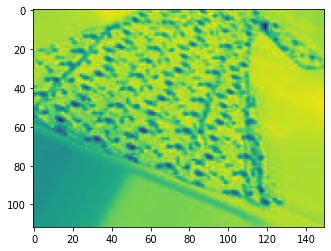


True class: Trouser
Predicted class: Footwear
Misclassified 63 times


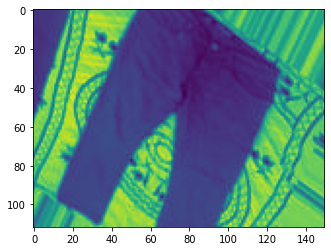


True class: Short
Predicted class: Footwear
Misclassified 31 times


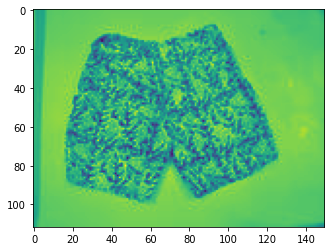


True class: Trouser
Predicted class: Dress
Misclassified 30 times


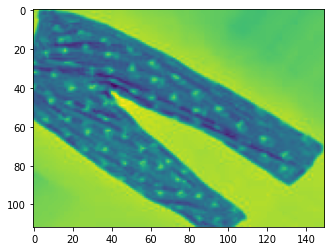


True class: Trouser
Predicted class: Topwear
Misclassified 28 times


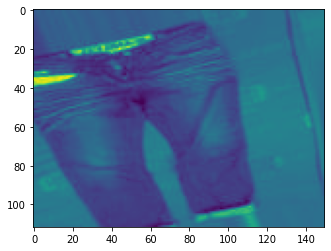


True class: Short
Predicted class: Dress
Misclassified 19 times


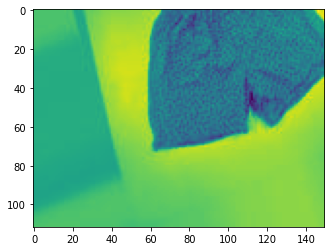


True class: Short
Predicted class: Topwear
Misclassified 15 times


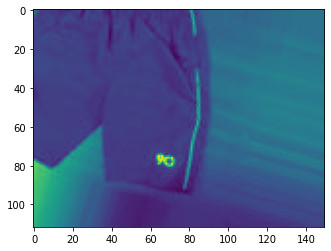


True class: Footwear
Predicted class: Dress
Misclassified 14 times


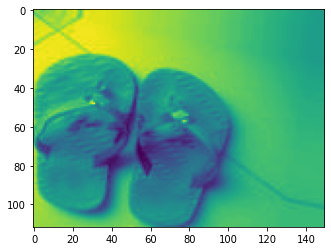


True class: Dress
Predicted class: Trouser
Misclassified 7 times


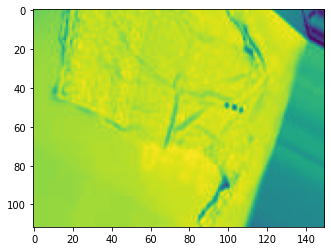


True class: Topwear
Predicted class: Dress
Misclassified 7 times


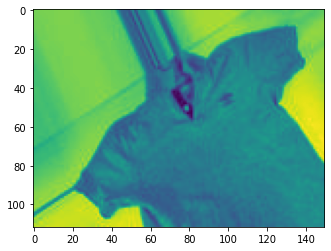

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


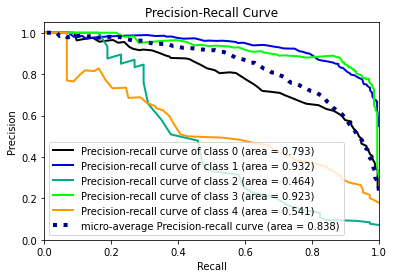

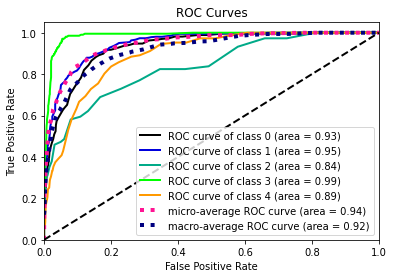

0 auc score: 0.931273976285962
1 auc score: 0.9485402105295533
2 auc score: 0.8356884803585312
3 auc score: 0.9856953888282936
4 auc score: 0.8917729400145992


In [20]:
analyze_model(model,test_X_2d, test_y)

2. Decision Tree Classifier

In [21]:
from sklearn.tree import DecisionTreeClassifier

In [22]:
dec_tree_clf = DecisionTreeClassifier(max_depth=50, random_state=42)
dec_tree_clf.fit(train_X_2d, train_y)

DecisionTreeClassifier(max_depth=50, random_state=42)

In [23]:
y_test_predict = dec_tree_clf.predict(test_X_2d)
dec_tree_accuracy = accuracy_score(test_y, y_test_predict)
dec_tree_precision = precision_score(test_y, y_test_predict, average='weighted')
dec_tree_recall = recall_score(test_y, y_test_predict, average='weighted')
dec_tree_f1_score = f1_score(test_y, y_test_predict, average='weighted')


print("Decision Tree Accuracy: ", dec_tree_accuracy)
print("Decision Tree Precision: ", dec_tree_precision)
print("Decision Tree Recall: ", dec_tree_precision)
print("Decision Tree F1 Score: ", dec_tree_f1_score)

Decision Tree Accuracy:  0.5477707006369427
Decision Tree Precision:  0.5656635749513199
Decision Tree Recall:  0.5656635749513199
Decision Tree F1 Score:  0.55585534638763


0.5477707006369427
Confusion matrix:
[[122  63  23  18  41]
 [ 94 377  27  13  52]
 [ 20  22  10   9  13]
 [ 13  11  11 142  28]
 [ 38  45  10  17  37]]

True class: Footwear
Predicted class: Dress
Misclassified 94 times


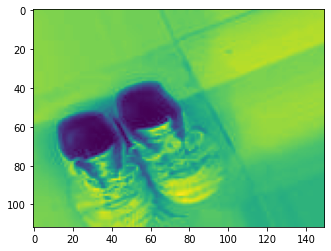


True class: Dress
Predicted class: Footwear
Misclassified 63 times


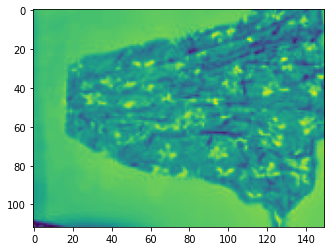


True class: Footwear
Predicted class: Trouser
Misclassified 52 times


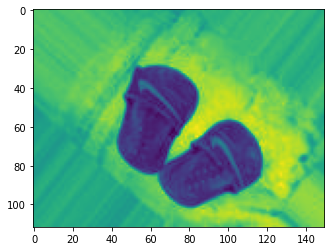


True class: Trouser
Predicted class: Footwear
Misclassified 45 times


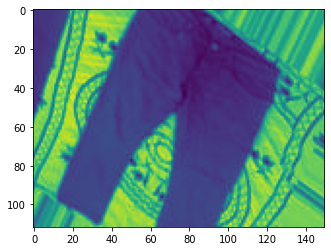


True class: Dress
Predicted class: Trouser
Misclassified 41 times


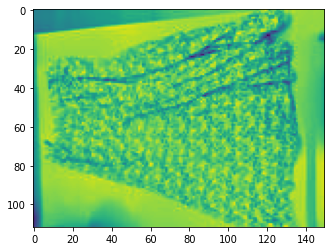


True class: Trouser
Predicted class: Dress
Misclassified 38 times


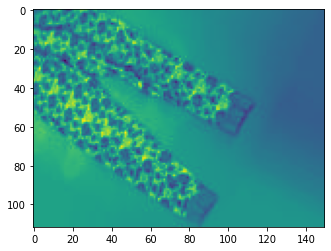


True class: Topwear
Predicted class: Trouser
Misclassified 28 times


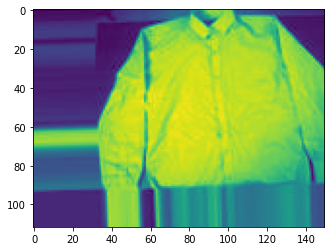


True class: Footwear
Predicted class: Short
Misclassified 27 times


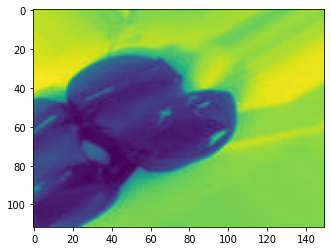


True class: Dress
Predicted class: Short
Misclassified 23 times


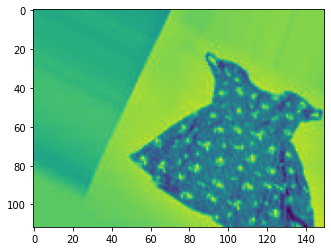


True class: Short
Predicted class: Footwear
Misclassified 22 times


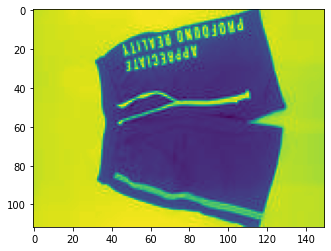

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


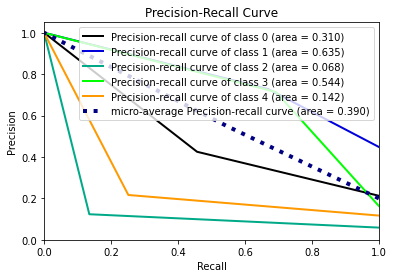

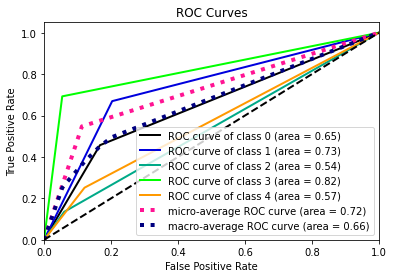

0 auc score: 0.6450468259468384
1 auc score: 0.7330818973802988
2 auc score: 0.5375337266200211
3 auc score: 0.8192244320159661
4 auc score: 0.5654355520386694


In [24]:
analyze_model(dec_tree_clf, test_X_2d, test_y)

3. SVM

In [ ]:
from sklearn import svm
clf = svm.SVC(gamma=0.1, kernel='poly', probability=True)
clf.fit(train_X_2d,train_y)

In [ ]:
y_pred = clf.predict(test_X_2d)

print('\nCalculating Accuracy of Predictions...')
accuracy = accuracy_score(test_y, y_pred)
print(accuracy)

In [ ]:
analyze_model(clf, test_X_2d, test_y)

4. Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
print(np.mean(cross_val_score(estimator=naive_bayes, cv=4, scoring='accuracy', X=train_X, y=train_y)))
naive_bayes.fit(train_X, train_y)

In [ ]:
analyze_model(naive_bayes, test_X, test_y)

5. XGBoost

In [ ]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(n_estimators=20, max_depth=10, random_state=42)
# Scaling is not needed for Decision Tree algorithm and hence for Random Forest and XGBoost algorithms as they 
# are also based on Decision Trees. Hence, not using scaled training data set here
# For max_depth parameter, typical values are between 3 to 10. We have chosen 10
xgb_clf.fit(train_X_2d, train_y)

In [ ]:
analyze_model(xgb_clf, test_X_2d, test_y)

6. CNN

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.metrics import sparse_categorical_accuracy, sparse_categorical_crossentropy

In [ ]:
class ConvModel:
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y, **kwargs):
        self.model.fit(X, y, **kwargs)
        
    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=1)

    def predict_proba(self, X):
        return self.model.predict(X)  

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='sigmoid', input_shape=(112, 150, 1)))
model.add(Conv2D(8, (3, 3), activation='sigmoid'))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

optimizer = keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=[sparse_categorical_accuracy])

conv_model_2c_1d = ConvModel(model)
conv_model_2c_1d.fit(train_X, train_y, batch_size=32, epochs=10, validation_data=(test_X, test_y))

In [ ]:
pickle.dump(conv_model_2c_1d, open('/content/drive/Shareddrives/AI ML Project/conv_model_2c_1d', "wb"))

In [ ]:
analyze_model(conv_model_2c_1d, test_X, test_y)

# 8. Compare multiple classifiers on the same data set and provide your observation

# 11. Perform post-processing on the output score to refine presentation

We initially had 9 categories. The accuracy score for the models was as follows:

1.   Random Forest - around 60%
2.   Decision Tree - around 50%
3.   CNNs - around 30%

After looking at the PR and ROC curves and also after analysing the mispredictions on some classes of the model, we have decided to combine the classes. Finally, we have 5 categories.
